Fully Convolutional Networks for Semantic Segmentation

Semantic Segmentation 문제를 위해 제안된 딥러닝 모델
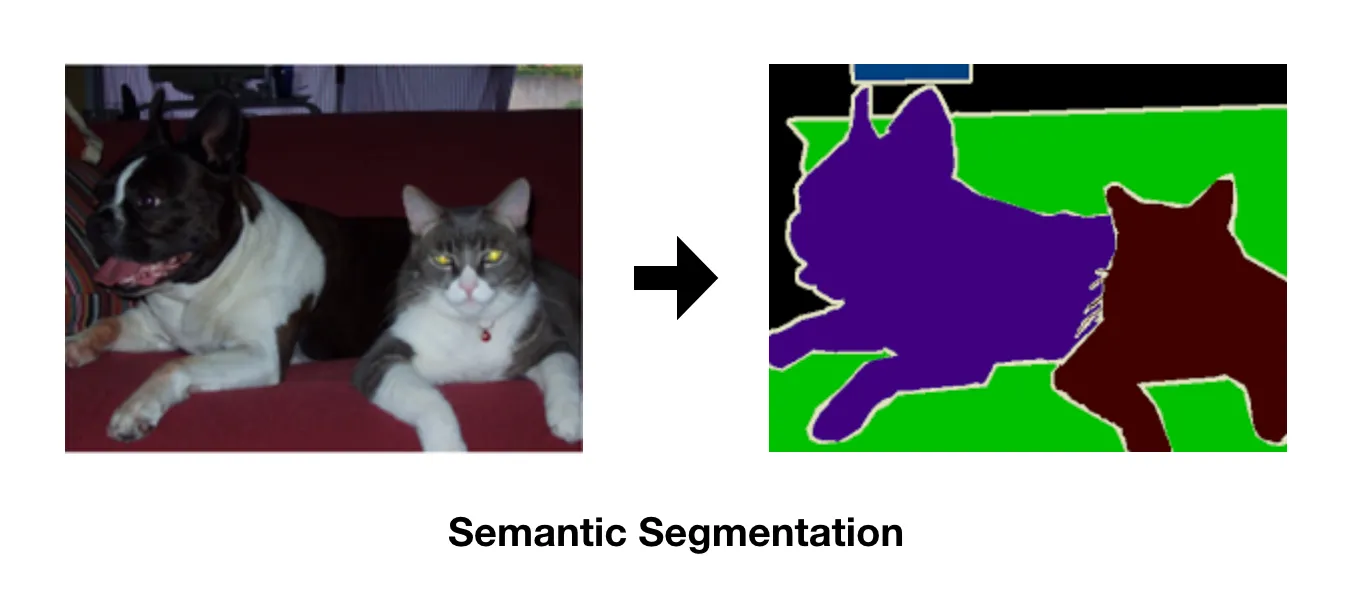

FCN은 Semantic Segmentation모델을 위해 기존에 이미지 분류에서 우수한 성능을 보인</br>
CNN기반 모델(AlexNet, VGG16, Inception)을 목적에 맞게 변형시킨것

이러한 [Image classification model] to [Semantic segmentation model]은 </br>
크게 다음의 세 과정으로 표현할 수 있다
- Convolutionalization
- Deconvolution(Upsampling)
- Skip arcchitecture

## Convolutionalization(컴볼루션화)

모든 CNN계열 모델의 문제 -> 마지막에 FC레이어가 낌</br>
이게 무슨 문제냐? **이미지의 위치 정보가 없어짐**</br>
<img src="../80_FCN/img/01.webp" alt="01" style="width:60%; height:60%;">

쉽게 얘기해서 고양이가 있는 사진은 '고양이'인건 알아차리는데 고양이가 어느 위치에 잇는지는 안알려줌

그리고 또다른 문제</br>
입력 이미지를 무조건 크기고정해야함</br>
<img src="../80_FCN/img/02.webp" alt="02" style="width:60%; height:60%;">

위 문제를 해결하기 위한 방법 : FC-layer을 Conv-layer로 대체한다.

이렇게 적용한 FCN의 출력 Feature map은 너무 작으면 픽셀 단위 예측이 무식해지기에</br>
입력 이미지 대비 1/32보다는 큰 사이즈를 유지해야함

## Deconvolution

Corse map(이미지의 초기 또는 중간 단계에서 얻어진 낮은 해상도의 특징 맵) 에서 </br>
Dense map(높은 해상도의 특징 맵, 네트워크의 후반부나, 이미지 복원단계에서 얻는 맵)

그러니까 중간과정을 수행하면서 크기가 작아진 Feature map에서 마지막 객체의 위치를 </br>
Segmentation하려고 만드는 후반부의 큰 사이즈 Feature map를 얻기 위한 방법은 아래 4가지가 있다.

- interpolation
- Deconvolution
- Unpooling (풀링레이어를 아에 안쓴느것 -> 이건 좀 노답..)
- Shift and stitch

### Deconvolution

기존 CNN -> 커널을 한칸한칸 이동하면서 픽셀에 대한 차근차근 예측하는것</br>
-> 중복이 많음 -> 비효율적

이 문제를 타계하기 위한 방안 : 그냥 한방에 예측하는것(커널사이즈 = 입력이미지 사이즈)
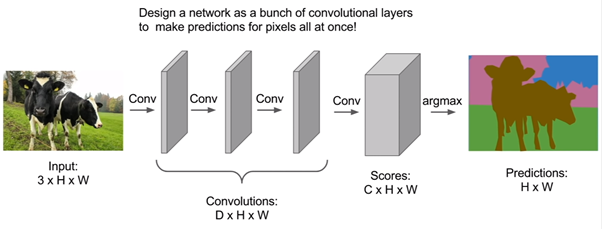
</br>-> 문제 : 메모리 + 컴퓨팅 코스트가 미친듯이 높아짐

해결방안 : Deconvolution -> 커널사이즈 = 입력이미지는 맞는데, 이 입력이미지를 줄이는것</br>
-> 나중에는 다시 복원함</br>
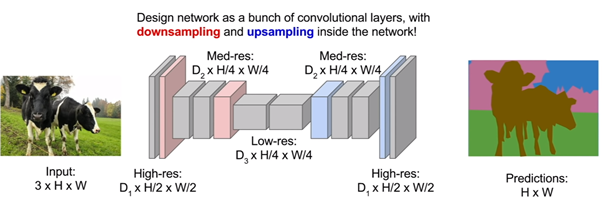

이 입력이미지를 줄인 만큼 채널을 늘리는 식으로 원본을 유지한다.

그럼 여기서 복원 과정에서 필연적으로 발생하는 'Upsampling'은 어떻게 수행?
- Nearest Neighbor : 복원해야 할 값을 가까운 값으로 복제
- Bed of Nails : 복원해야 할 값을 0으로 처리
- Max Unpooling : Max Pooling 때 버린 값을 따로 기억해 두었다가 복원


### interpolation
10x10이미지를 320x320으로 확장하려면 어떻게 해야할까?</br>
Bilinear interpolation 방법론</br>
<img src="../80_FCN/img/06.webp" alt="02" style="width:50%; height:50%;">

위 수식을 2차원 이미지로 확장하는 것이다.</br>
<img src="../80_FCN/img/07.webp" alt="02" style="width:70%; height:70%;">



그리고 Conv연산을 역으로 수행하는 Backwards Convolution방법론도 씀

<img src="../80_FCN/img/08.webp" alt="02" style="width:50%; height:50%;">

아무튼 FCN은 Bilinear interpolation과 Backwards convolution</br>
두 가지 방법을 사용하여 Coarse Feature map으로부터 Dense prediction을 구함</br>
<img src="../80_FCN/img/09.webp" alt="02" style="width:80%; height:80%;">
</br>기본 뼈대가 되는 모델은 VGG임

<div style="display: flex; align-items: flex-start;">
    <div style="flex: 1;">
        <img src="./img/10.webp" alt="image2" style="max-width: 100%; height: 60%;">
    </div>
    <div style="flex: 1; padding-left: 10px;">
        그러나 Bilinear interpolation는 문제가 있음 
        </br>-> 예측 결과가 허술함
        </br>이 문제를 해결하기 위한 방법 : Skip Architecture
        </br>일단 알아둘 개념 : 아래 이미지
        <img src="./img/11.webp" alt="image2" style="max-width: 100%; height: 60%;">
    </div>
</div>



CNN계열의 층별 주로 확인되는 정보들</br>
맨 위에층(얕은 층) : 직선, 곡선, 색상 같은것</br> -> Local Feature
맨 아래층(깊은 층) : 개체 정보 ===> Global Feature

이 정보를 바탕으로 얕은 층에서 얻은 정보를 깊은 층에 더하는 식으로 Segmentation 품질을 개선함

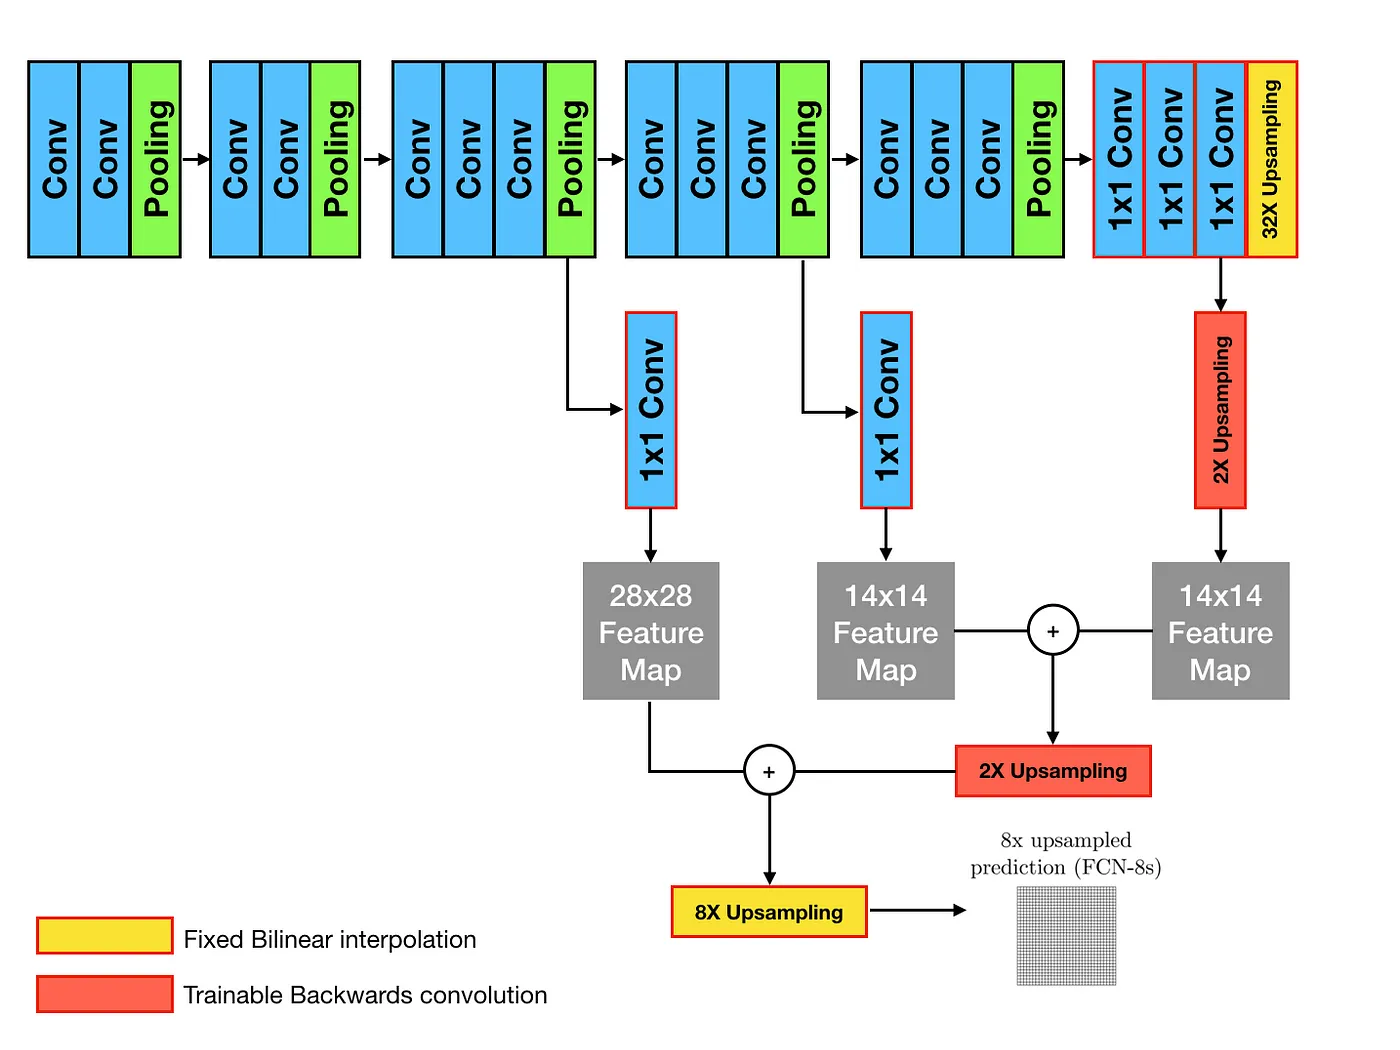

## FCN 코드 구현
FCN은 기본적으로 VGGNet를 기반으로 한다.

일단 첫번째로 VGG16Net를 먼저 구현한다.

In [1]:
import torch
import torch.nn as nn

In [2]:
class conv2_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv2_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,**kwargs)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels,out_channels,**kwargs)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)

        return x


In [3]:
class conv3_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv3_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,**kwargs)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels,out_channels,**kwargs)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(out_channels,out_channels,**kwargs)
        self.relu3 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool1(x)
        return x

In [4]:
class VGG16(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(VGG16, self).__init__()

        self.block1 = conv2_block(in_channels, 64, kernel_size=3, padding=1)
        self.block2 = conv2_block(64, 128, kernel_size=3, padding=1)
        self.block3 = conv3_block(128, 256, kernel_size=3, padding=1)
        self.block4 = conv3_block(256, 512, kernel_size=3, padding=1)
        self.block5 = conv3_block(512, 512, kernel_size=3, padding=1)

        #x = x.view(x.size(0), -1)을 대체하는 Flatten코드 사용
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Assuming input image size is 224x224
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x5 = self.block5(x4)
        
        return x1, x2, x3, x4, x5


위 설계된 VGG Net를 기반으로 FCN코드 구현

In [5]:
import torch.nn.functional as F

In [6]:
class FCN(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN, self).__init__()
        self.vgg = VGG16()

        self.relu = nn.ReLU(inplace=True)

        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.vgg(x)

        score = self.bn1(self.relu(self.deconv1(x5)))
        score = score + F.interpolate(x4, score.size()[2:], mode='bilinear', align_corners=True)
        
        score = self.bn2(self.relu(self.deconv2(score)))
        score = score + F.interpolate(x3, score.size()[2:], mode='bilinear', align_corners=True)
        
        score = self.bn3(self.relu(self.deconv3(score)))
        score = score + F.interpolate(x2, score.size()[2:], mode='bilinear', align_corners=True)
        
        score = self.bn4(self.relu(self.deconv4(score)))
        score = score + F.interpolate(x1, score.size()[2:], mode='bilinear', align_corners=True)
        
        score = self.bn5(self.relu(self.deconv5(score)))
        score = self.classifier(score)

        return score

### 위 코드에서 설명할 부분
`nn.ConvTranspose2d` : Conv의 역연산을 하는 코드임</br>
`F.interpolate` : FCN모델 설명할 때 Pooling의 반대개념인 Upsampling할 때 보간법

**중요**
FCN모델이 개발된 시점에는 `nn.BatchNorm2d`이 없었음
</br>지금은 성능을 좀 더 올리려고 넣은거임

In [7]:
from torchsummary import summary #설계한 모델의 요약본 출력 모듈

debug_model = FCN()
summary(debug_model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
       conv2_block-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
      conv2_block-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
             ReLU-14          [-1, 256,

## 데이터셋 전처리
FCN논문은 PASCAL VOC, SIFT Flow데이터셋을 활용함

여기서 Pascal VOC를 사용하기로 하자..



In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation

import numpy as np

import os

In [9]:
# Define the transform for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

root_dir = './data/VOCdevkit/VOC2012'

if not os.path.exists(root_dir):
    # Load the PASCAL VOC 2012 dataset
    train_dataset = VOCSegmentation(root='./data', 
                                    year='2012', 
                                    image_set='train', 
                                    download=True, 
                                    transform=transform, 
                                    target_transform=transform)
    val_dataset = VOCSegmentation(root='./data', 
                                  year='2012', 
                                  image_set='val', 
                                  download=True, 
                                  transform=transform, 
                                  target_transform=transform)
else:
    # Load the dataset without downloading
    train_dataset = VOCSegmentation(root='./data', 
                                    year='2012', 
                                    image_set='train', 
                                    download=False, 
                                    transform=transform, 
                                    target_transform=transform)
    val_dataset = VOCSegmentation(root='./data', 
                                  year='2012', 
                                  image_set='val', 
                                  download=False, 
                                  transform=transform, 
                                  target_transform=transform)
# Load the PASCAL VOC 2012 dataset



In [10]:
from PIL import Image

# Function to get the number of classes
# def get_dataset_info(dataset):
#     classes = set()
#     for _, target in dataset:
#         # Convert PIL Image to numpy array
#         target = np.array(target)
#         # Flatten the array and update the set with unique values
#         classes.update(target.flatten())
#     num_classes = len(classes)
#     num_images = len(dataset)
#     return num_classes, num_images
# # Calculate the number of classes
# num_classes, num_train_images = get_dataset_info(train_dataset)
# _, num_val_images = get_dataset_info(val_dataset)

# # Print dataset information
# print(f'Number of classes: {num_classes}')
# print(f'Number of training images: {num_train_images}')
# print(f'Number of validation images: {num_val_images}')

num_classes = 21

#하이퍼 파라미터 - 배치사이즈
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CUDA가 사용 가능한 경우, 추가 정보 출력
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")  # GB 단위로 변환
    print(f"Number of GPUs: {torch.cuda.device_count()}")

cuda
GPU Name: NVIDIA GeForce RTX 4090 Laptop GPU
GPU Capability: (8, 9)
Total Memory: 15.99 GB
Number of GPUs: 1


In [12]:
ex_model = FCN(num_classes = num_classes)
ex_model.to(device)
summary(ex_model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
       conv2_block-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
      conv2_block-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
             ReLU-14          [-1, 256,

## 옵티마이저 및 손실함수 정의

손실함수 : 다중 클래스 로그 손실(multi-class log loss)</br>
`nn.CrossEntropyLoss`와 동일함

옵티마이저 : stochastic gradient descent (SGD)

옵티마이저의 하이퍼 파라미터
- momentum = 0.9
- learning_rate = 1e-3
- weight_decay = 5e-4

In [13]:
# from torch import optim

# momentum = 0.9
# learning_rate = 1e-3
# weight_decay = 5e-4

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(ex_model.parameters(), lr=learning_rate, 
#                       momentum=momentum, weight_decay=weight_decay)

In [14]:
#하지만 아담버전의 옵티마이저를 쓰자...
from torch import optim

learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ex_model.parameters(), lr=learning_rate)

### 훈련 함수 및 검증함수 만들기

In [15]:
from tqdm import tqdm #훈련 진행상황 체크

def model_train(model, data_loader, loss_fn, optimizer_fn, processing_device):
    model.train()

    # loss와 accuracy를 계산하기 위한 임시 변수를 생성
    run_size, run_loss, correct_pixels = 0, 0, 0

    # 이때 사용되는 데이터는 훈련용 데이터
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))

    for batch_idx, (images, masks) in progress_bar:

        images = images.to(processing_device)
        masks = masks.squeeze(1).long().to(processing_device)

        # 전사 과정 수행
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        # Backward pass and optimization
        optimizer_fn.zero_grad()
        loss.backward()
        optimizer_fn.step()

        # 여기부터는 학습이 잘 되고 있는지 확인하는 부분
        preds = outputs.argmax(dim=1)
        correct_pixels += preds.eq(masks).sum().item()

        run_loss += loss.item() * images.size(0)
        run_size += images.size(0)
        progress_bar.set_description('[Training] loss: ' +
                                     f'{run_loss / run_size:.4f}, accuracy: ' +
                                     f'{correct_pixels / (run_size * images.size(2) * images.size(3)):.4f}')

    accuracy = correct_pixels / (run_size * images.size(2) * images.size(3))
    avg_loss = run_loss / len(data_loader.dataset)

    return avg_loss, accuracy


In [16]:
def calculate_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
    return np.array(ious)

In [17]:
def model_evaluate(model, data_loader, loss_fn, processing_device, num_classes):
    model.eval()  # 모델을 평가 모드로 전환

    # gradient 업데이트를 방지해주자
    with torch.no_grad():
        # 여기서도 loss, accuracy 계산을 위한 임시 변수 선언
        run_loss, correct_pixels, total_pixels = 0, 0, 0
        ious = []

        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc="[Evaluating]")

        for batch_idx, (images, masks) in progress_bar:
            images = images.to(processing_device)
            masks = masks.squeeze(1).long().to(processing_device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)

            run_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)

            #iou를 계산해야
            iou = calculate_iou(preds, masks, num_classes)
            ious.append(iou)

            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

        mean_iou = np.nanmean(np.array(ious), axis=0).mean()
        avg_loss = run_loss / len(data_loader.dataset)
        accuracy = correct_pixels / total_pixels

        return avg_loss, mean_iou, accuracy

### 실행 및 결과 확인

In [18]:
# 학습과 검증 손실 및 정확도를 저장할 리스트
his_loss, his_accuracy = [], []

num_epoch = 100

for epoch in range(num_epoch):
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(ex_model, train_loader, criterion, optimizer, device)
    print(f"epoch {epoch+1:03d}, Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_iou, val_acc = model_evaluate(ex_model, val_loader, criterion, device, num_classes)
    print(f"Validation loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Validation accuracy: {val_acc:.4f}")

    # 손실과 정확도를 리스트에 저장
    his_loss.append((train_loss, val_loss))
    his_accuracy.append((train_acc, val_acc))


# 학습이 완료된 모델 저장
MODEL_NAME = 'FCN_VOC'
torch.save(ex_model.state_dict(), f'{MODEL_NAME}.pth')

[Training] loss: 3.2512, accuracy: 0.0225: 100%|██████████| 46/46 [00:26<00:00,  1.76it/s]


epoch 001, Training loss: 3.2512, Training accuracy: 0.0225


[Evaluating]: 100%|██████████| 46/46 [00:17<00:00,  2.60it/s]
C:\Users\Z13_ASH\AppData\Local\Temp\ipykernel_17484\1154570233.py:29: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(np.array(ious), axis=0).mean()


Validation loss: 3.2108, Validation IoU: nan, Validation accuracy: 0.0001


[Training] loss: 3.1848, accuracy: 0.0166: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 002, Training loss: 3.1848, Training accuracy: 0.0166


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 3.1378, Validation IoU: 0.0008, Validation accuracy: 0.0123


[Training] loss: 3.1422, accuracy: 0.0618: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 003, Training loss: 3.1422, Training accuracy: 0.0618


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.96it/s]


Validation loss: 3.1332, Validation IoU: 0.0095, Validation accuracy: 0.1223


[Training] loss: 3.0953, accuracy: 0.3009: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 004, Training loss: 3.0953, Training accuracy: 0.3009


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 3.2514, Validation IoU: 0.0217, Validation accuracy: 0.3610


[Training] loss: 3.0485, accuracy: 0.4949: 100%|██████████| 46/46 [00:26<00:00,  1.70it/s]


epoch 005, Training loss: 3.0485, Training accuracy: 0.4949


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s]


Validation loss: 3.0007, Validation IoU: 0.0327, Validation accuracy: 0.5761


[Training] loss: 3.0016, accuracy: 0.6012: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 006, Training loss: 3.0016, Training accuracy: 0.6012


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 3.1921, Validation IoU: 0.0296, Validation accuracy: 0.5261


[Training] loss: 2.9501, accuracy: 0.6681: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 007, Training loss: 2.9501, Training accuracy: 0.6681


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 3.8026, Validation IoU: 0.0264, Validation accuracy: 0.4836


[Training] loss: 2.8929, accuracy: 0.7187: 100%|██████████| 46/46 [00:27<00:00,  1.66it/s]


epoch 008, Training loss: 2.8929, Training accuracy: 0.7187


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.83it/s]


Validation loss: 3.1637, Validation IoU: 0.0362, Validation accuracy: 0.6604


[Training] loss: 2.8271, accuracy: 0.7483: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 009, Training loss: 2.8271, Training accuracy: 0.7483


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 3.0380, Validation IoU: 0.0400, Validation accuracy: 0.7280


[Training] loss: 2.7549, accuracy: 0.7709: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 010, Training loss: 2.7549, Training accuracy: 0.7709


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.94it/s]


Validation loss: 2.7897, Validation IoU: 0.0426, Validation accuracy: 0.7712


[Training] loss: 2.6736, accuracy: 0.7955: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 011, Training loss: 2.6736, Training accuracy: 0.7955


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 2.1646, Validation IoU: 0.0473, Validation accuracy: 0.8511


[Training] loss: 2.5893, accuracy: 0.8174: 100%|██████████| 46/46 [00:26<00:00,  1.72it/s]


epoch 012, Training loss: 2.5893, Training accuracy: 0.8174


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 2.4766, Validation IoU: 0.0452, Validation accuracy: 0.8116


[Training] loss: 2.5005, accuracy: 0.8365: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 013, Training loss: 2.5005, Training accuracy: 0.8365


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.94it/s]


Validation loss: 2.3365, Validation IoU: 0.0477, Validation accuracy: 0.8562


[Training] loss: 2.4084, accuracy: 0.8502: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 014, Training loss: 2.4084, Training accuracy: 0.8502


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.83it/s]


Validation loss: 2.0306, Validation IoU: 0.0493, Validation accuracy: 0.8871


[Training] loss: 2.3113, accuracy: 0.8622: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 015, Training loss: 2.3113, Training accuracy: 0.8622


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.86it/s]


Validation loss: 3.4523, Validation IoU: 0.0428, Validation accuracy: 0.7785


[Training] loss: 2.2193, accuracy: 0.8749: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 016, Training loss: 2.2193, Training accuracy: 0.8749


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.86it/s]


Validation loss: 2.3913, Validation IoU: 0.0478, Validation accuracy: 0.8588


[Training] loss: 2.0863, accuracy: 0.8907: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 017, Training loss: 2.0863, Training accuracy: 0.8907


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 1.8282, Validation IoU: 0.0498, Validation accuracy: 0.9059


[Training] loss: 1.9676, accuracy: 0.8967: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 018, Training loss: 1.9676, Training accuracy: 0.8967


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 1.7493, Validation IoU: 0.0499, Validation accuracy: 0.9039


[Training] loss: 1.8323, accuracy: 0.9094: 100%|██████████| 46/46 [00:27<00:00,  1.66it/s]


epoch 019, Training loss: 1.8323, Training accuracy: 0.9094


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.78it/s]


Validation loss: 1.3526, Validation IoU: 0.0492, Validation accuracy: 0.9333


[Training] loss: 1.7069, accuracy: 0.9160: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 020, Training loss: 1.7069, Training accuracy: 0.9160


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 1.2570, Validation IoU: 0.0495, Validation accuracy: 0.9286


[Training] loss: 1.5607, accuracy: 0.9263: 100%|██████████| 46/46 [00:25<00:00,  1.79it/s]


epoch 021, Training loss: 1.5607, Training accuracy: 0.9263


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.86it/s]


Validation loss: 1.2640, Validation IoU: 0.0491, Validation accuracy: 0.9275


[Training] loss: 1.4307, accuracy: 0.9316: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 022, Training loss: 1.4307, Training accuracy: 0.9316


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


Validation loss: 2.0745, Validation IoU: 0.0489, Validation accuracy: 0.8872


[Training] loss: 1.2926, accuracy: 0.9386: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


epoch 023, Training loss: 1.2926, Training accuracy: 0.9386


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 1.0665, Validation IoU: 0.0494, Validation accuracy: 0.9321


[Training] loss: 1.1994, accuracy: 0.9417: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 024, Training loss: 1.1994, Training accuracy: 0.9417


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.9660, Validation IoU: 0.0489, Validation accuracy: 0.9370


[Training] loss: 1.0742, accuracy: 0.9467: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 025, Training loss: 1.0742, Training accuracy: 0.9467


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.9571, Validation IoU: 0.0491, Validation accuracy: 0.9356


[Training] loss: 0.9659, accuracy: 0.9496: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 026, Training loss: 0.9659, Training accuracy: 0.9496


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.8518, Validation IoU: 0.0484, Validation accuracy: 0.9367


[Training] loss: 0.8999, accuracy: 0.9514: 100%|██████████| 46/46 [00:26<00:00,  1.72it/s]


epoch 027, Training loss: 0.8999, Training accuracy: 0.9514


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 1.0212, Validation IoU: 0.0496, Validation accuracy: 0.9303


[Training] loss: 0.8070, accuracy: 0.9537: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 028, Training loss: 0.8070, Training accuracy: 0.9537


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


Validation loss: 0.6668, Validation IoU: 0.0475, Validation accuracy: 0.9423


[Training] loss: 0.7390, accuracy: 0.9548: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 029, Training loss: 0.7390, Training accuracy: 0.9548


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.6368, Validation IoU: 0.0483, Validation accuracy: 0.9414


[Training] loss: 0.6819, accuracy: 0.9556: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 030, Training loss: 0.6819, Training accuracy: 0.9556


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.5872, Validation IoU: 0.0471, Validation accuracy: 0.9432


[Training] loss: 0.6152, accuracy: 0.9570: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 031, Training loss: 0.6152, Training accuracy: 0.9570


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.96it/s]


Validation loss: 0.5640, Validation IoU: 0.0476, Validation accuracy: 0.9411


[Training] loss: 0.5647, accuracy: 0.9580: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


epoch 032, Training loss: 0.5647, Training accuracy: 0.9580


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.94it/s]


Validation loss: 0.4904, Validation IoU: 0.0476, Validation accuracy: 0.9423


[Training] loss: 0.5372, accuracy: 0.9583: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


epoch 033, Training loss: 0.5372, Training accuracy: 0.9583


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 0.5599, Validation IoU: 0.0485, Validation accuracy: 0.9389


[Training] loss: 0.4968, accuracy: 0.9589: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 034, Training loss: 0.4968, Training accuracy: 0.9589


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.4739, Validation IoU: 0.0476, Validation accuracy: 0.9427


[Training] loss: 0.4501, accuracy: 0.9603: 100%|██████████| 46/46 [00:26<00:00,  1.76it/s]


epoch 035, Training loss: 0.4501, Training accuracy: 0.9603


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 0.4475, Validation IoU: 0.0472, Validation accuracy: 0.9433


[Training] loss: 0.4167, accuracy: 0.9608: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 036, Training loss: 0.4167, Training accuracy: 0.9608


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.4413, Validation IoU: nan, Validation accuracy: 0.9423


[Training] loss: 0.3812, accuracy: 0.9612: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 037, Training loss: 0.3812, Training accuracy: 0.9612


[Evaluating]: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Validation loss: 0.4173, Validation IoU: nan, Validation accuracy: 0.9423


[Training] loss: 0.3747, accuracy: 0.9612: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 038, Training loss: 0.3747, Training accuracy: 0.9612


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.83it/s]


Validation loss: 0.4088, Validation IoU: nan, Validation accuracy: 0.9427


[Training] loss: 0.3566, accuracy: 0.9609: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 039, Training loss: 0.3566, Training accuracy: 0.9609


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.88it/s]


Validation loss: 0.3854, Validation IoU: nan, Validation accuracy: 0.9436


[Training] loss: 0.3263, accuracy: 0.9619: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 040, Training loss: 0.3263, Training accuracy: 0.9619


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


Validation loss: 0.4007, Validation IoU: nan, Validation accuracy: 0.9416


[Training] loss: 0.2869, accuracy: 0.9635: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 041, Training loss: 0.2869, Training accuracy: 0.9635


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.86it/s]


Validation loss: 0.3788, Validation IoU: nan, Validation accuracy: 0.9430


[Training] loss: 0.2923, accuracy: 0.9628: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 042, Training loss: 0.2923, Training accuracy: 0.9628


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 0.3526, Validation IoU: nan, Validation accuracy: 0.9438


[Training] loss: 0.2689, accuracy: 0.9632: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 043, Training loss: 0.2689, Training accuracy: 0.9632


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 0.3713, Validation IoU: nan, Validation accuracy: 0.9435


[Training] loss: 0.2458, accuracy: 0.9643: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 044, Training loss: 0.2458, Training accuracy: 0.9643


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


Validation loss: 0.3682, Validation IoU: nan, Validation accuracy: 0.9427


[Training] loss: 0.2414, accuracy: 0.9642: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 045, Training loss: 0.2414, Training accuracy: 0.9642


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s]


Validation loss: 0.3740, Validation IoU: nan, Validation accuracy: 0.9430


[Training] loss: 0.2410, accuracy: 0.9639: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 046, Training loss: 0.2410, Training accuracy: 0.9639


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.3722, Validation IoU: nan, Validation accuracy: 0.9425


[Training] loss: 0.2287, accuracy: 0.9644: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


epoch 047, Training loss: 0.2287, Training accuracy: 0.9644


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 0.3383, Validation IoU: nan, Validation accuracy: 0.9419


[Training] loss: 0.2090, accuracy: 0.9645: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


epoch 048, Training loss: 0.2090, Training accuracy: 0.9645


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 0.3457, Validation IoU: nan, Validation accuracy: 0.9413


[Training] loss: 0.2034, accuracy: 0.9649: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 049, Training loss: 0.2034, Training accuracy: 0.9649


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.83it/s]


Validation loss: 0.3475, Validation IoU: nan, Validation accuracy: 0.9412


[Training] loss: 0.1959, accuracy: 0.9650: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 050, Training loss: 0.1959, Training accuracy: 0.9650


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 0.3552, Validation IoU: nan, Validation accuracy: 0.9417


[Training] loss: 0.1892, accuracy: 0.9653: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 051, Training loss: 0.1892, Training accuracy: 0.9653


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 0.3464, Validation IoU: nan, Validation accuracy: 0.9433


[Training] loss: 0.1757, accuracy: 0.9663: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 052, Training loss: 0.1757, Training accuracy: 0.9663


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.88it/s]


Validation loss: 0.3610, Validation IoU: nan, Validation accuracy: 0.9413


[Training] loss: 0.1656, accuracy: 0.9670: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


epoch 053, Training loss: 0.1656, Training accuracy: 0.9670


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.82it/s]


Validation loss: 0.3405, Validation IoU: nan, Validation accuracy: 0.9396


[Training] loss: 0.1636, accuracy: 0.9665: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 054, Training loss: 0.1636, Training accuracy: 0.9665


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3392, Validation IoU: nan, Validation accuracy: 0.9413


[Training] loss: 0.1612, accuracy: 0.9667: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 055, Training loss: 0.1612, Training accuracy: 0.9667


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 0.3414, Validation IoU: nan, Validation accuracy: 0.9423


[Training] loss: 0.1500, accuracy: 0.9675: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 056, Training loss: 0.1500, Training accuracy: 0.9675


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 0.3343, Validation IoU: nan, Validation accuracy: 0.9426


[Training] loss: 0.1422, accuracy: 0.9678: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 057, Training loss: 0.1422, Training accuracy: 0.9678


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3324, Validation IoU: nan, Validation accuracy: 0.9424


[Training] loss: 0.1453, accuracy: 0.9679: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 058, Training loss: 0.1453, Training accuracy: 0.9679


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.87it/s]


Validation loss: 0.3327, Validation IoU: nan, Validation accuracy: 0.9437


[Training] loss: 0.1346, accuracy: 0.9684: 100%|██████████| 46/46 [00:26<00:00,  1.70it/s]


epoch 059, Training loss: 0.1346, Training accuracy: 0.9684


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 0.3263, Validation IoU: nan, Validation accuracy: 0.9405


[Training] loss: 0.1348, accuracy: 0.9682: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 060, Training loss: 0.1348, Training accuracy: 0.9682


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 0.3525, Validation IoU: nan, Validation accuracy: 0.9418


[Training] loss: 0.1276, accuracy: 0.9690: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 061, Training loss: 0.1276, Training accuracy: 0.9690


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 0.3423, Validation IoU: nan, Validation accuracy: 0.9407


[Training] loss: 0.1241, accuracy: 0.9691: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 062, Training loss: 0.1241, Training accuracy: 0.9691


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


Validation loss: 0.3319, Validation IoU: nan, Validation accuracy: 0.9430


[Training] loss: 0.1187, accuracy: 0.9695: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 063, Training loss: 0.1187, Training accuracy: 0.9695


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 0.3138, Validation IoU: nan, Validation accuracy: 0.9410


[Training] loss: 0.1216, accuracy: 0.9694: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 064, Training loss: 0.1216, Training accuracy: 0.9694


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 0.3610, Validation IoU: nan, Validation accuracy: 0.9407


[Training] loss: 0.1119, accuracy: 0.9698: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 065, Training loss: 0.1119, Training accuracy: 0.9698


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3430, Validation IoU: nan, Validation accuracy: 0.9420


[Training] loss: 0.1109, accuracy: 0.9703: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 066, Training loss: 0.1109, Training accuracy: 0.9703


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.3479, Validation IoU: nan, Validation accuracy: 0.9414


[Training] loss: 0.1042, accuracy: 0.9710: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 067, Training loss: 0.1042, Training accuracy: 0.9710


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 0.3654, Validation IoU: nan, Validation accuracy: 0.9414


[Training] loss: 0.1039, accuracy: 0.9708: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 068, Training loss: 0.1039, Training accuracy: 0.9708


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.82it/s]


Validation loss: 0.3336, Validation IoU: nan, Validation accuracy: 0.9427


[Training] loss: 0.1011, accuracy: 0.9714: 100%|██████████| 46/46 [00:26<00:00,  1.72it/s]


epoch 069, Training loss: 0.1011, Training accuracy: 0.9714


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 0.3445, Validation IoU: nan, Validation accuracy: 0.9407


[Training] loss: 0.1003, accuracy: 0.9718: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 070, Training loss: 0.1003, Training accuracy: 0.9718


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3478, Validation IoU: nan, Validation accuracy: 0.9413


[Training] loss: 0.0991, accuracy: 0.9719: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 071, Training loss: 0.0991, Training accuracy: 0.9719


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.3662, Validation IoU: nan, Validation accuracy: 0.9392


[Training] loss: 0.0918, accuracy: 0.9724: 100%|██████████| 46/46 [00:26<00:00,  1.73it/s]


epoch 072, Training loss: 0.0918, Training accuracy: 0.9724


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 0.3471, Validation IoU: nan, Validation accuracy: 0.9412


[Training] loss: 0.0898, accuracy: 0.9728: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 073, Training loss: 0.0898, Training accuracy: 0.9728


[Evaluating]: 100%|██████████| 46/46 [00:17<00:00,  2.69it/s]


Validation loss: 0.3453, Validation IoU: nan, Validation accuracy: 0.9412


[Training] loss: 0.0880, accuracy: 0.9731: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 074, Training loss: 0.0880, Training accuracy: 0.9731


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.75it/s]


Validation loss: 0.3706, Validation IoU: nan, Validation accuracy: 0.9409


[Training] loss: 0.0839, accuracy: 0.9738: 100%|██████████| 46/46 [00:27<00:00,  1.66it/s]


epoch 075, Training loss: 0.0839, Training accuracy: 0.9738


[Evaluating]: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Validation loss: 0.3746, Validation IoU: nan, Validation accuracy: 0.9420


[Training] loss: 0.0822, accuracy: 0.9738: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 076, Training loss: 0.0822, Training accuracy: 0.9738


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 0.3665, Validation IoU: nan, Validation accuracy: 0.9348


[Training] loss: 0.0811, accuracy: 0.9743: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 077, Training loss: 0.0811, Training accuracy: 0.9743


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3662, Validation IoU: nan, Validation accuracy: 0.9405


[Training] loss: 0.0818, accuracy: 0.9746: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 078, Training loss: 0.0818, Training accuracy: 0.9746


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 0.3519, Validation IoU: nan, Validation accuracy: 0.9423


[Training] loss: 0.0763, accuracy: 0.9752: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 079, Training loss: 0.0763, Training accuracy: 0.9752


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.86it/s]


Validation loss: 0.3764, Validation IoU: nan, Validation accuracy: 0.9397


[Training] loss: 0.0825, accuracy: 0.9745: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 080, Training loss: 0.0825, Training accuracy: 0.9745


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3474, Validation IoU: nan, Validation accuracy: 0.9407


[Training] loss: 0.0788, accuracy: 0.9747: 100%|██████████| 46/46 [00:27<00:00,  1.67it/s]


epoch 081, Training loss: 0.0788, Training accuracy: 0.9747


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 0.3590, Validation IoU: nan, Validation accuracy: 0.9418


[Training] loss: 0.0768, accuracy: 0.9750: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 082, Training loss: 0.0768, Training accuracy: 0.9750


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 0.3797, Validation IoU: nan, Validation accuracy: 0.9368


[Training] loss: 0.0707, accuracy: 0.9762: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 083, Training loss: 0.0707, Training accuracy: 0.9762


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3763, Validation IoU: nan, Validation accuracy: 0.9397


[Training] loss: 0.0684, accuracy: 0.9771: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 084, Training loss: 0.0684, Training accuracy: 0.9771


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.93it/s]


Validation loss: 0.3812, Validation IoU: nan, Validation accuracy: 0.9379


[Training] loss: 0.0688, accuracy: 0.9770: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 085, Training loss: 0.0688, Training accuracy: 0.9770


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.86it/s]


Validation loss: 0.3912, Validation IoU: nan, Validation accuracy: 0.9362


[Training] loss: 0.0661, accuracy: 0.9775: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 086, Training loss: 0.0661, Training accuracy: 0.9775


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3864, Validation IoU: nan, Validation accuracy: 0.9368


[Training] loss: 0.0631, accuracy: 0.9782: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 087, Training loss: 0.0631, Training accuracy: 0.9782


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.85it/s]


Validation loss: 0.3884, Validation IoU: nan, Validation accuracy: 0.9366


[Training] loss: 0.0682, accuracy: 0.9773: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 088, Training loss: 0.0682, Training accuracy: 0.9773


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


Validation loss: 0.3527, Validation IoU: nan, Validation accuracy: 0.9407


[Training] loss: 0.0646, accuracy: 0.9780: 100%|██████████| 46/46 [00:24<00:00,  1.85it/s]


epoch 089, Training loss: 0.0646, Training accuracy: 0.9780


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Validation loss: 0.3838, Validation IoU: nan, Validation accuracy: 0.9385


[Training] loss: 0.0614, accuracy: 0.9788: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 090, Training loss: 0.0614, Training accuracy: 0.9788


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


Validation loss: 0.4078, Validation IoU: nan, Validation accuracy: 0.9357


[Training] loss: 0.0600, accuracy: 0.9792: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 091, Training loss: 0.0600, Training accuracy: 0.9792


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.94it/s]


Validation loss: 0.3806, Validation IoU: nan, Validation accuracy: 0.9396


[Training] loss: 0.0590, accuracy: 0.9797: 100%|██████████| 46/46 [00:26<00:00,  1.71it/s]


epoch 092, Training loss: 0.0590, Training accuracy: 0.9797


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.88it/s]


Validation loss: 0.3977, Validation IoU: nan, Validation accuracy: 0.9400


[Training] loss: 0.0587, accuracy: 0.9798: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 093, Training loss: 0.0587, Training accuracy: 0.9798


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.4011, Validation IoU: nan, Validation accuracy: 0.9364


[Training] loss: 0.0562, accuracy: 0.9803: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 094, Training loss: 0.0562, Training accuracy: 0.9803


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.86it/s]


Validation loss: 0.3982, Validation IoU: nan, Validation accuracy: 0.9360


[Training] loss: 0.0555, accuracy: 0.9807: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 095, Training loss: 0.0555, Training accuracy: 0.9807


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


Validation loss: 0.3840, Validation IoU: nan, Validation accuracy: 0.9409


[Training] loss: 0.0528, accuracy: 0.9808: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 096, Training loss: 0.0528, Training accuracy: 0.9808


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.88it/s]


Validation loss: 0.4158, Validation IoU: nan, Validation accuracy: 0.9355


[Training] loss: 0.0539, accuracy: 0.9812: 100%|██████████| 46/46 [00:27<00:00,  1.68it/s]


epoch 097, Training loss: 0.0539, Training accuracy: 0.9812


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.95it/s]


Validation loss: 0.3958, Validation IoU: nan, Validation accuracy: 0.9377


[Training] loss: 0.0505, accuracy: 0.9821: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 098, Training loss: 0.0505, Training accuracy: 0.9821


[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Validation loss: 0.4111, Validation IoU: nan, Validation accuracy: 0.9395


[Training] loss: 0.0493, accuracy: 0.9825: 100%|██████████| 46/46 [00:27<00:00,  1.70it/s]


epoch 099, Training loss: 0.0493, Training accuracy: 0.9825


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.82it/s]


Validation loss: 0.3993, Validation IoU: nan, Validation accuracy: 0.9385


[Training] loss: 0.0487, accuracy: 0.9828: 100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


epoch 100, Training loss: 0.0487, Training accuracy: 0.9828


[Evaluating]: 100%|██████████| 46/46 [00:16<00:00,  2.84it/s]


Validation loss: 0.4114, Validation IoU: nan, Validation accuracy: 0.9380


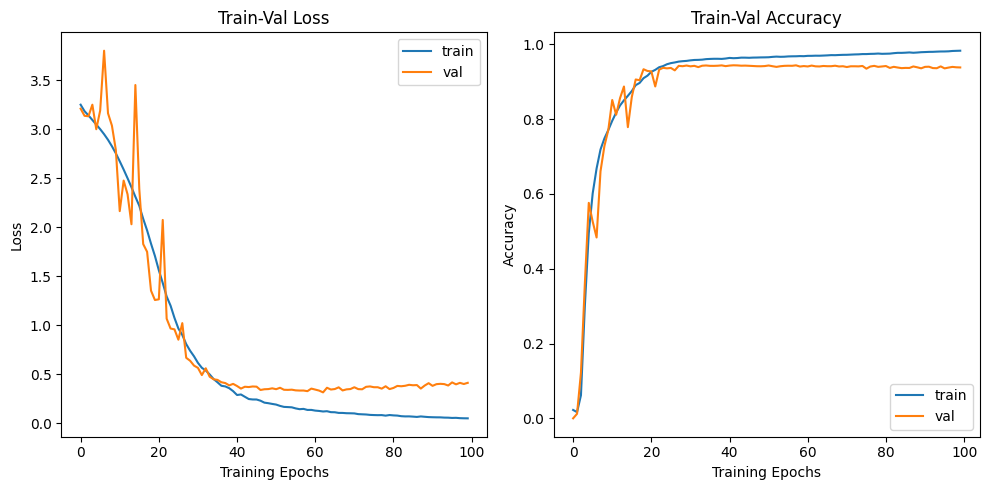

In [19]:
import matplotlib.pyplot as plt

# 손실 그래프
train_losses, val_losses = zip(*his_loss)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# 정확도 그래프
train_accuracies, val_accuracies = zip(*his_accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train-Val Accuracy')

plt.tight_layout()
plt.show()

[Evaluating]: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]
C:\Users\Z13_ASH\AppData\Local\Temp\ipykernel_17484\1154570233.py:29: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(np.array(ious), axis=0).mean()


evaluation loss: 0.41136, evaluation IoU: nan, evaluation accuracy: 0.93805


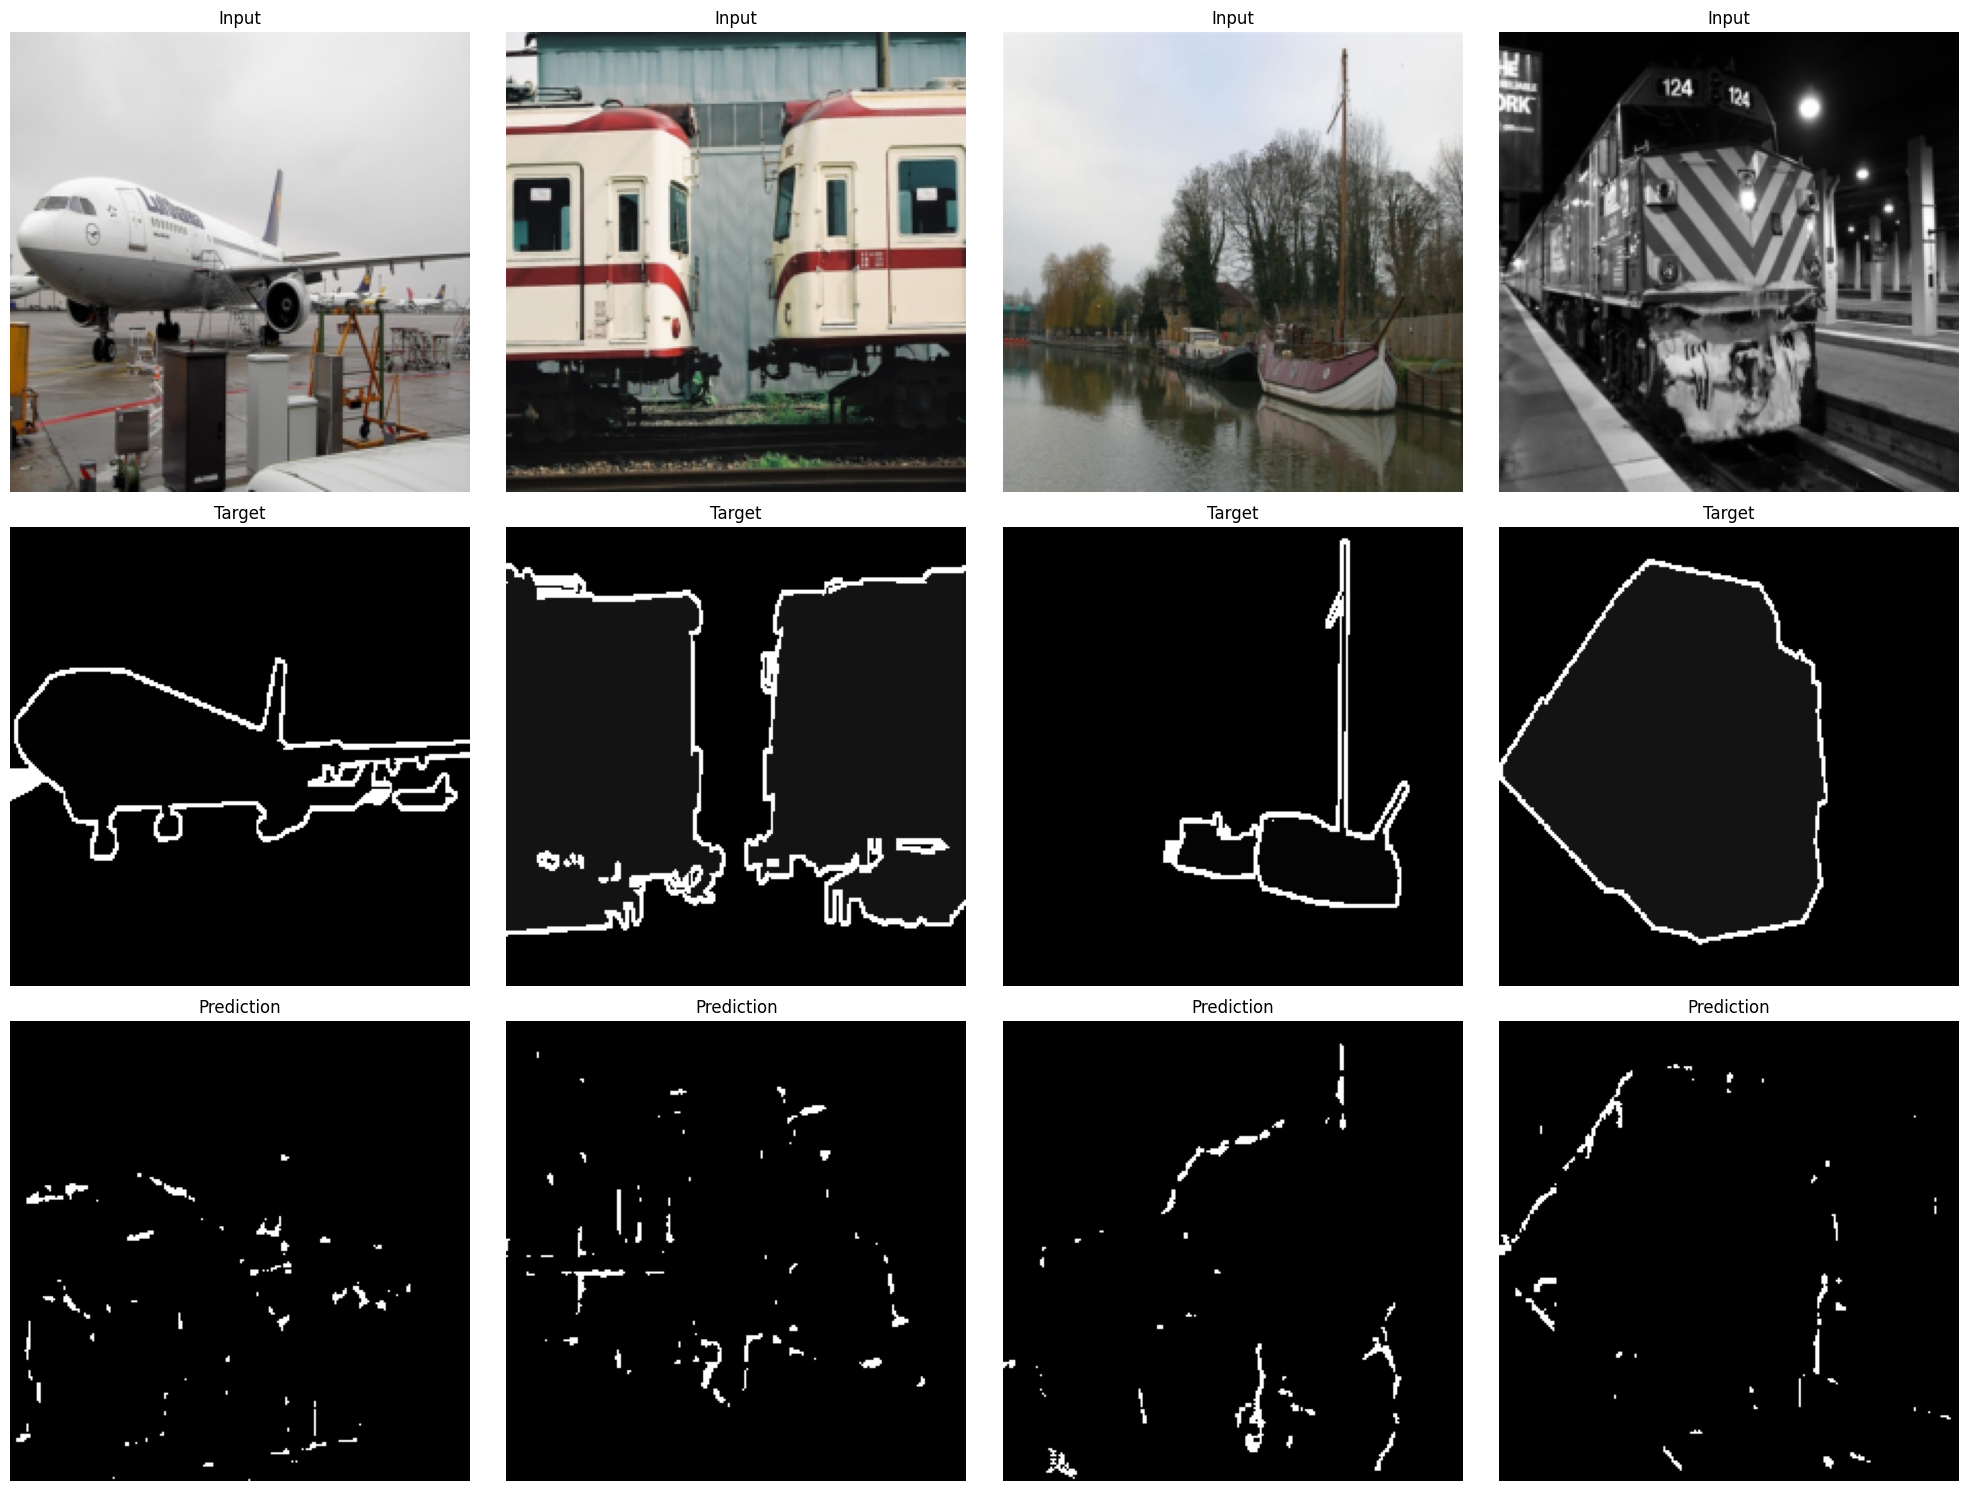

In [20]:
import random

# 모델 로드
ex_model.load_state_dict(torch.load(f'{MODEL_NAME}.pth'))
ex_model.to(device)

# 모델 평가
final_loss, final_iou, final_acc = model_evaluate(ex_model, val_loader, criterion, device, num_classes)
print(f'evaluation loss: {final_loss:.5f}, evaluation IoU: {final_iou:.5f}, evaluation accuracy: {final_acc:.5f}')

# 테스트 이미지 시각화
def visualize_predictions(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        # 무작위로 한 배치를 가져옵니다.
        images, masks = next(iter(data_loader))
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        # CPU로 데이터 이동
        images = images.cpu()
        masks = masks.squeeze(1).cpu()  # 채널 제거
        preds = preds.cpu()
        
        # 시각화를 위해 첫 4개 이미지 선택
        num_images = 4
        fig, axes = plt.subplots(3, num_images, figsize=(num_images * 5, 15))
        
        for i in range(num_images):
            axes[0, i].imshow(images[i].permute(1, 2, 0))
            axes[0, i].set_title('Input')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(masks[i], cmap='gray')
            axes[1, i].set_title('Target')
            axes[1, i].axis('off')
            
            axes[2, i].imshow(preds[i], cmap='gray')
            axes[2, i].set_title('Prediction')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# 시각화 함수 호출
visualize_predictions(ex_model, val_loader, device)